**Toki Pona Modeling**

First, I'll pull in my data so that we can run same basic statistics on it.

We'll make a clone of the poki lapo repository into the file poki

```git clone https://github.com/kulupu-lapo/poki.git```

We'll also clone the old nltk-tp project

```git clone https://github.com/davidar/nltk-tp.git```

Poki lapo is currently the largest and most complete corpus of Toki Pona data

There is a structure inside the repository, but since we only care about the plaintext, we can simply toss away the headers and use the plaintext.






In [136]:
#I'm not doing this without type checking
%load_ext nb_mypy 
#you'll need to run "mypy --install-types" to get the types for installed packages

#We'll import the packages we'll use for this
import nltk
from nltk import ngrams
from collections import Counter
import re
import os
import random
import warnings
import strip_markdown #to remove markdown formatting
import pickle
from tabulate import tabulate
from tqdm import tqdm

PUNCTUATION = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

import matplotlib.pyplot as plt

def print_divider():
    print("\n" + "="*40 + "\n")

<>:18: SyntaxWarning: invalid escape sequence '\,'
<>:18: SyntaxWarning: invalid escape sequence '\,'
<unknown>:18: SyntaxWarning: invalid escape sequence '\,'


The nb_mypy extension is already loaded. To reload it, use:
  %reload_ext nb_mypy


C:\Users\frank\AppData\Local\Temp\ipykernel_2364\3919779807.py:18: SyntaxWarning: invalid escape sequence '\,'
  PUNCTUATION = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''


In [137]:
#We'll open all files in poki directory and read them, stripping the header\
poki_plaintext_path = './poki/plaintext/'

all_files_paths = []
#all the text files in poki directory that we will read end in ".md"
for root, dirs, files in os.walk(poki_plaintext_path):
    for file in files:
        if file.endswith('.md'):
            print(os.path.join(root, file))
            all_files_paths.append(os.path.join(root, file))

print(f"Total files found: {len(all_files_paths)}")

<unknown>:929: SyntaxWarning: invalid escape sequence '\,'


./poki/plaintext/2002\10\jan-uluka-li-pilin-ike.md
./poki/plaintext/2002\10\kili-lili.md
./poki/plaintext/2002\10\sijelo-pi-nasin-pona.md
./poki/plaintext/2002\10\tenpo-suno-ni-iwa.md
./poki/plaintext/2002\10\toki-pona.md
./poki/plaintext/2002\10\tomo-palisa-pi-papeli.md
./poki/plaintext/2003\04\pilin-ike.md
./poki/plaintext/2003\04\wan-taso.md
./poki/plaintext/2003\05\ma-tomo-pape.md
./poki/plaintext/2003\05\mama-pi-mi-mute.md
./poki/plaintext/2004\06\lipu-sewi.md
./poki/plaintext/2004\06\o-toki-pi-jan-sewi.md
./poki/plaintext/2004\06\son-23.md
./poki/plaintext/2005\07\ma-tomo-pape.md
./poki/plaintext/2005\09\toki-utala-Supaka.md
./poki/plaintext/2005\12\wan-taso.md
./poki/plaintext/2006\02\lipu-pi-jan-pona-sewi-matejo.md
./poki/plaintext/2007\06\blue-sky.md
./poki/plaintext/2007\06\kalama-nasa-wawa.md
./poki/plaintext/2007\06\melissa.md
./poki/plaintext/2007\06\midnight-rider.md
./poki/plaintext/2007\06\revival.md
./poki/plaintext/2007\06\sina-olin-o-toki.md
./poki/plaintext/2008\unk

Now that we have the list of all the files, we will do some preprocessing on it.
We strip out the headers, as we don't care about the header data.
I change lines formatted like: 
```Hello there   \ ```
to ```Hello there.```.

A significant amount of the corpus is poetic, or at least not formatted like normal text, so this helps make that segment more regular.

Toki Pona doesn't really require punctuation by convention, so often text will just end in a newline. I add a '.' to all lines ending without punctuation. This will likely screw up some multi line sentences but those are not nearly as many as sentences that end on a newline. Overall, its a trade-off well worth taking.

In [138]:
def read_and_clean_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        # Remove header (header is starting with '---' and ending with '---')
        if content.startswith('---'):
            header_end = content.find('---', 3)
            if header_end != -1:
                content = content[header_end + 3:].lstrip()
        else:
            #this is just to notify us if a file has no header, but we can still process it
            warnings.warn(f"No header found in file: {file_path}")
        # Remove markdown formatting
        clean_content = strip_markdown.strip_markdown(content)
        # There are many lines that end in '[some amount of whitespace]\' instead of a '.' We will terminate these lines with a period.
        clean_content = re.sub(r'.?\s+\\\n', '.\n', clean_content)
        # We will also replace multiple newlines with a single newline
        clean_content = re.sub(r'\n+', '\n', clean_content)
        # We will terminate any line that does not end with a punctuation mark with a period.
        clean_content = re.sub(r'([^\.\!\?\n\"\,\:])\n', r'\1.\n', clean_content)
        return clean_content
    
#Now, lets see if this worked by reading one file
sample_file_path = random.choice(all_files_paths)
print(f"Reading file: {sample_file_path}")
original_content = open(sample_file_path, 'r', encoding='utf-8').read()
cleaned_content = read_and_clean_file(sample_file_path)

table = [
    ["Original Content", "Cleaned Content"],
    [original_content, cleaned_content]
]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

Reading file: ./poki/plaintext/2014\12\04-lipu-tili.md
╒═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Original Content                                                                                                                                                                                                                                          │ Cleaned Content                                                                                                                                                                          

Now that our data is somewhat cleaned up from the formatting, we need to train our punkt tokenizer.
Punkt tokenizers need to be trained on a large volume of data, but it is unsupervised so I'll just use the whole dataset.

Since we've done some manual cleanup, this shouldn't be too bad.
Unfortunately, there is still a lot of data that we have that isn't very clean, but the tokenizer is capable enough to work anyway. 

One quirk of the Punkt is that it puts punctuation as its own token. This is helpful sometimes, but sometimes we don't want punctuation counting as a token.

In [139]:
#Only do this if we have not already trained and saved a tokenizer
if os.path.exists('trained_sentence_tokenizer.pkl'):
    print("Trained tokenizer already exists. Skipping training.")
else:
    tokenizer = nltk.tokenize.PunktSentenceTokenizer()
    tokenizer.train(' '.join([read_and_clean_file(fp) for fp in all_files_paths]))

    #We'll save the trained tokenizer for future use
    #Since it's not too large, we can just pickle it
    with open('trained_sentence_tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    print("Trained sentence tokenizer saved as 'trained_sentence_tokenizer.pkl'")

#Now, we can use this tokenizer to tokenize sentences in any of the files


Trained tokenizer already exists. Skipping training.


In [140]:
#We'll load the trained tokenizer from the pickle file
with open('trained_sentence_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f) # type: ignore

#Let's tokenize sentences in a sample file
sample_file_path = random.choice(all_files_paths)
print(f"Tokenizing sentences in file: {sample_file_path}")
cleaned_content = read_and_clean_file(sample_file_path)
sentences = tokenizer.tokenize(cleaned_content)
print(f"Total sentences found: {len(sentences)}")
for i, sentence in enumerate(sentences[:5]):  # print first 5 sentences
    print(f"Sentence {i+1}: {sentence}")
print_divider()
print(cleaned_content[:sum(len(s) for s in sentences[:5]) + 20])  # print content of first 5 sentences

<cell>2: error: Incompatible types in assignment (expression has type "BufferedReader[_BufferedReaderStream]", variable has type "BufferedWriter")  [assignment]


Tokenizing sentences in file: ./poki/plaintext/2025\01\jan-li-suno-musi-e-sewi-pimeja.md
Total sentences found: 7
Sentence 1: jan pi tenpo mi o awen.
Sentence 2: lon sona anu seme.
Sentence 3: jan en tenpo pini.
Sentence 4: o weka ala weka tan sona.
Sentence 5: o awen e tenpo pona.


jan pi tenpo mi o awen.
lon sona anu seme.
jan en tenpo pini.
o weka ala weka tan sona.
o awen e tenpo pona.
lon sona, jan m


In [141]:
#Now that we have a trained tokenizer, we can use it to tokenize all files. I'll generate 1-4gram frequency distributions across all files.
all_sentences = []
print("Tokenizing all files...")
for file_path in tqdm(all_files_paths):
    cleaned_content = read_and_clean_file(file_path)
    sentences = tokenizer.tokenize(cleaned_content)
    all_sentences.extend(sentences)

print (f"Total sentences tokenized from all files: {len(all_sentences)}")
print("Examples of tokenized sentences:")
for sentence in all_sentences[:5]:
    print(" - " + sentence)

Tokenizing all files...


100%|██████████| 1529/1529 [00:07<00:00, 196.96it/s]

Total sentences tokenized from all files: 97772
Examples of tokenized sentences:
 - jan Uluka wan li pana e telo oko.
 - jan Uluka li wan, li pilin ike.
 - jan Uluka ni li wile e seme?
 - seli li pona tawa jan Uluka.
 - moku e luka jan li pona tawa jan Uluka.


In [142]:
#Tokenize all sentences into words, then generate n-grams

# Tokenize sentences into words
all_tokens = []
print("Tokenizing...")
for sentence in tqdm(all_sentences):
    words = nltk.word_tokenize(sentence)

    all_tokens.extend(words)
all_words = [w for w in all_tokens if w not in PUNCTUATION]


print("Token sample:")
print(all_tokens[230:250])
print("Words sample:")
print(all_words[230:250])


print(f"Total words: {len(all_tokens)}")
print(f"Unique words: {len(set(all_tokens))}")
print()

print("Generating n-grams and counting frequencies...")

# Generate n-grams (1-4) and count frequencies
n_token_freqs = {}  # Store frequency distributions for each n
n_word_freqs = {}
for n in tqdm(range(1, 5)):
    n_grams = list(ngrams(all_tokens, n))
    n_token_freqs[n] = Counter(n_grams)
    n_grams = list(ngrams(all_words, n))
    n_word_freqs[n] = Counter(n_grams)

# Print results for each n
for n in range(1, 5):
    print(f"=== {n}-grams (top 5 out of {len(n_token_freqs[n])}) ===")
    for gram, count in n_token_freqs[n].most_common(5):
        gram_str = ' '.join(gram) if isinstance(gram, tuple) else gram
        print(f"  {count:5d}x  {gram_str}")


Tokenizing...


100%|██████████| 97772/97772 [00:04<00:00, 21131.38it/s]



Token sample:
['selo', 'pi', 'jan', 'Uluka', '!', 'kaso', 'li', 'lon', '!', 'waso', 'mute', 'li', 'lon', '!', 'waso', 'mute', 'li', 'pana', 'e', 'kalama']
Words sample:
['Uluka', 'li', 'wile', 'e', 'luka', 'jan', 'insa', 'uta', 'jan', 'Uluka', 'li', 'pilin', 'ike', 'mi', 'jo', 'e', 'kili', 'ona', 'li', 'pona']
Total words: 1068685
Unique words: 10858

Generating n-grams and counting frequencies...


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

=== 1-grams (top 5 out of 10858) ===
  84784x  .
  82309x  li
  48631x  e
  33798x  jan
  32942x  mi
=== 2-grams (top 5 out of 55241) ===
  16028x  ona li
  12550x  la ,
   8996x  . jan
   8939x  ni li
   8561x  ni :
=== 3-grams (top 5 out of 236512) ===
   5624x  . ona li
   5497x  e ni :
   3179x  toki e ni
   3097x  li toki e
   2492x  ni la ,
=== 4-grams (top 5 out of 533196) ===
   2322x  li toki e ni
   2320x  toki e ni :
   1442x  -- -+ -- -+
   1389x  la , ona li
   1231x  -+ -- -+ --


In [143]:

# Define a plotting function for unigram frequency charts
def plot_unigrams(words_dict, title, color, top_n=140, figsize=(14, 6)):
    """
    Plot top n unigrams from a words frequency dictionary.
    
    Args:
        words_dict: Dictionary mapping words to frequency counts
        title: Title for the plot
        color: matplotlib color specification
        top_n: Number of top unigrams to display (default: 140)
        figsize: Figure size as (width, height) tuple (default: (14, 6))
    """
    common = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    labels = [w for w, _ in common]
    counts = [c for _, c in common]
    
    plt.figure(figsize=figsize)
    plt.bar(range(len(labels)), counts, color=color, width=0.8)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=7)
    plt.title(title)
    plt.xlabel("Unigram")
    plt.ylabel("Frequency")
    
    # Annotate bars with counts
    for i, c in enumerate(counts):
        plt.text(i, c, str(c), rotation=90, va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return common, labels, counts


In [144]:
# Prepare Toki Pona data for plotting
unigrams = n_word_freqs.get(1)  # We use n_word_freqs because we don't want '.' as the most common token.
if unigrams is None:
    raise RuntimeError("n_word_freqs[1] not found")

# Convert Counter to dictionary for consistent format
toki_pona_words_dict = dict(unigrams)

print(f"Prepared {len(toki_pona_words_dict)} Toki Pona unigrams for plotting")


Prepared 10831 Toki Pona unigrams for plotting


Now that we have the counts, we can compare against the counts from the nltk-tp project by David A Roberts (davidar) and against an English word counts. I've acquired a list for English word counts from [wordfrequency.info](https://www.wordfrequency.info/samples.asp)

In [145]:
# Load nltk-tp 1-gram frequencies
NLTK_1GRAM_FILE_PATH = "./nltk-tp/words.txt"

# Parse the file into standard format
nltk_words_dict = {}
with open(NLTK_1GRAM_FILE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line[0] == '#' or not line:
            continue
        parts = line.split()
        if len(parts) >= 2:
            count = int(parts[0])
            word = parts[1]
            nltk_words_dict[word] = count

print(f"Loaded {len(nltk_words_dict)} nltk-tp words")


<cell>6: error: Incompatible types in assignment (expression has type "TextIOWrapper[_WrappedBuffer]", variable has type "BufferedWriter")  [assignment]


Loaded 131 nltk-tp words


In [146]:
# Load English 1-gram frequencies
import csv

ENGLISH_1GRAM_FILE_PATH = "./data/wordFrequency.csv"

# Parse the CSV file into standard format
# CSV format: rank, lemma, PoS, freq, ...
english_words_dict = {}
with open(ENGLISH_1GRAM_FILE_PATH, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0:  # skip header
            continue
        if len(row) >= 4:
            try:
                word = row[1]  # lemma is column 1
                count = int(row[3])  # freq is column 3
                english_words_dict[word] = count
            except (ValueError, IndexError):
                continue

print(f"Loaded {len(english_words_dict)} English words")


<cell>9: error: Incompatible types in assignment (expression has type "TextIOWrapper[_WrappedBuffer]", variable has type "BufferedWriter")  [assignment]
<cell>10: error: Argument 1 to "reader" has incompatible type "BufferedWriter"; expected "Iterable[str]"  [arg-type]
<cell>10: note: Following member(s) of "BufferedWriter" have conflicts:
<cell>10: note:     Expected:
<cell>10: note:         def __iter__(self) -> Iterator[str]
<cell>10: note:     Got:
<cell>10: note:         def __iter__(self) -> Iterator[bytes]
<cell>10: error: Argument 1 to "reader" has incompatible type "BufferedWriter"; expected "Iterable[str]"  [arg-type]
<cell>10: note: Following member(s) of "BufferedWriter" have conflicts:
<cell>10: note:     Expected:
<cell>10: note:         def __iter__(self) -> Iterator[str]
<cell>10: note:     Got:
<cell>10: note:         def __iter__(self) -> Iterator[bytes]


Loaded 4380 English words



Generating comparison plots...



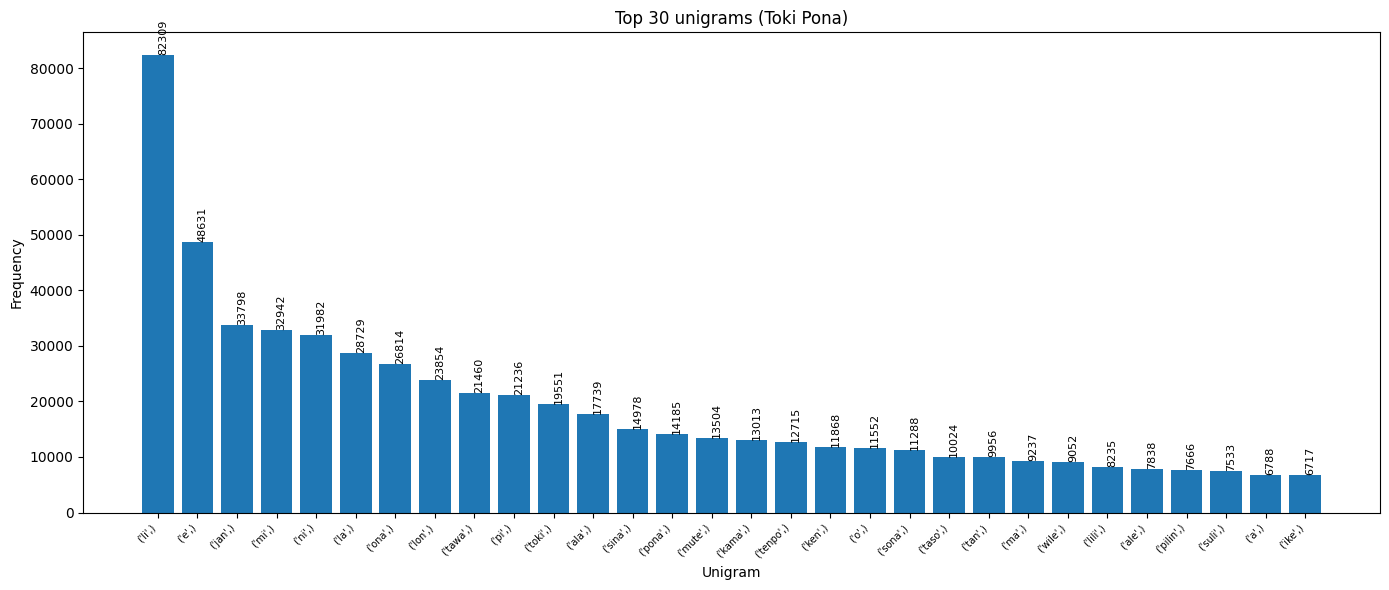

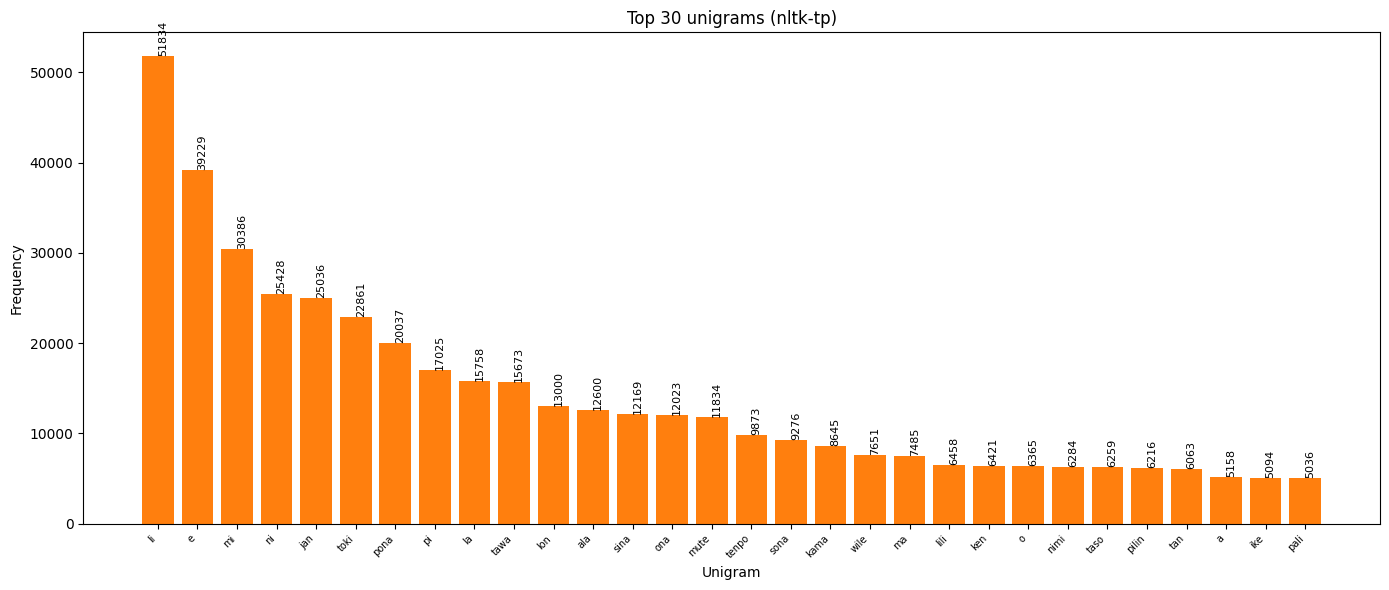

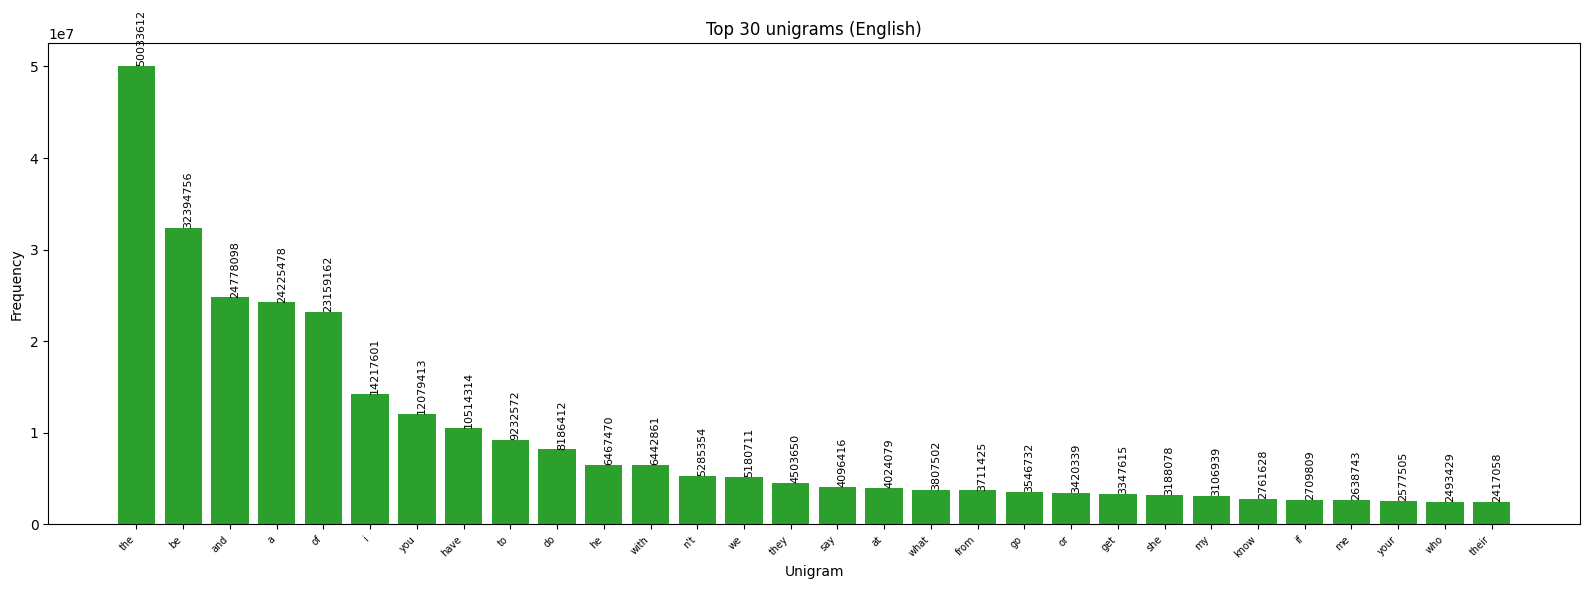


Comparison plots generated!


In [147]:
# Plot all three frequency charts for comparison
print("\nGenerating comparison plots...\n")

top_n = 30

# Plot Toki Pona
plot_unigrams(toki_pona_words_dict, f"Top {top_n} unigrams (Toki Pona)", "C0", top_n=top_n, figsize=(14, 6))

# Plot nltk-tp
plot_unigrams(nltk_words_dict, f"Top {top_n} unigrams (nltk-tp)", "C1", top_n=top_n, figsize=(14, 6))

# Plot English
plot_unigrams(english_words_dict, f"Top {top_n} unigrams (English)", "C2", top_n=top_n, figsize=(16, 6))

print("\nComparison plots generated!")


These plots look pretty similar, which isn't terribly surprising. Noticeably though, English falls to a lower level much faster, while the 30th entries for Toki Pona are much higher. 